In [1]:
import os
import pandas as pd
import plotly.express as px
import geopandas as gpd
from shapely.geometry import Point,Polygon
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import folium
from folium.plugins import FastMarkerCluster
import random
import numpy as np
import scipy.spatial
from haversine import haversine
RANDOM_SEED = 1234
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
data = pd.read_csv("clustering_sample.csv")
data = data.iloc[:,:4]
df  = data.copy()

In [2]:
df.isnull().sum()

point_id     0
latitude     0
longitude    0
weight       0
dtype: int64

In [3]:
##First Start the Analysis with Kmeans algo without considering the weights

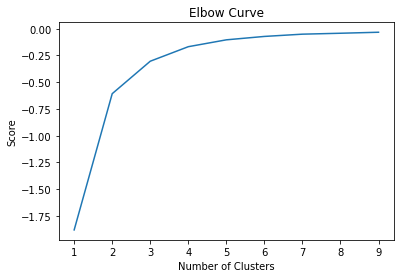

In [4]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df[['latitude']]
X_axis = df[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [5]:
kmeans = KMeans(n_clusters = 5, init ='k-means++')
kmeans.fit(df[df.columns[1:3]]) # Compute k-means clustering.
df['cluster_label'] = kmeans.fit_predict(df[df.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(df[df.columns[1:3]]) # Labels of each point
df.head(10)

,point_id,latitude,longitude,weight,cluster_label
0,379839017,12.856261,77.787511,5,4
1,622780526,12.843469,77.536688,2,2
2,294600617,12.976655,77.639975,1,1
3,160818599,12.855278,77.586485,1,2
4,32679861,12.843120,77.670582,2,4
5,250845312,13.017458,77.698665,1,1
6,695961681,12.953537,77.697951,2,1
7,169723338,12.977135,77.742475,4,1
8,872454868,13.042593,77.612939,3,3
9,60499367,12.789400,77.504066,4,2


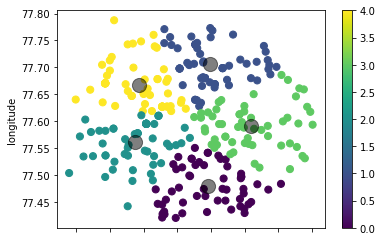

In [6]:
df.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [7]:
## Weighted K means Clustering with Haversine Distance

In [8]:
lats=data['latitude'].to_list()
lons=data['longitude'].to_list()

In [9]:
m= folium.Map(
    location=[12.85,77.65],
    zoom_start=10.45,tiles='Stamen Toner')
folium.LayerControl().add_to(m)

for row in data.iterrows():
    row=row[1]
    folium.CircleMarker(location=(row["latitude"],
                                  row["longitude"]),
                        radius= row['weight'],
                        color="#007849",
                        popup=row['point_id'],
                        fill=False).add_to(m)   
display(m)



In [10]:

def distance(p1,p2):
  return haversine(p1[1:],p2[1:])
def cluster_centroids(data, clusters, k):
  results=[]
  for i in range(k):
    results.append(np.average(data[clusters == i],weights=np.squeeze(np.asarray(data[clusters == i][:,[0]])),axis=0))
  return results
def kmeans(data, k=None, centroids=None, steps=30):
  # Forgy initialization method: choose k data points randomly.
  centroids = data[np.random.choice(np.arange(len(data)), k, False)]
  elbow = []
  for _ in range(max(steps, 1)):
    sqdists = scipy.spatial.distance.cdist(centroids, data, lambda u, v: (distance(u,v)**2))
    elbow.append(sqdists)
    #sse=np.sum((np.mean(elbow)-elbow)**2)
    # Index of the closest centroid to each data point.
    clusters = np.argmin(sqdists, axis=0)
    new_centroids = cluster_centroids(data, clusters, k)
    if np.array_equal(new_centroids, centroids):
      break
    centroids = new_centroids
  
  return clusters, centroids,elbow

In [11]:
vals = data[['weight','latitude','longitude']].values
sse=[]
for k in range(1,10):
    clusters,centroids,elbow=kmeans(vals,k)
    sqdist = np.sum((elbow-np.mean(elbow))**2)
    sse.append(sqdist)
sse=sorted(sse,reverse=True)

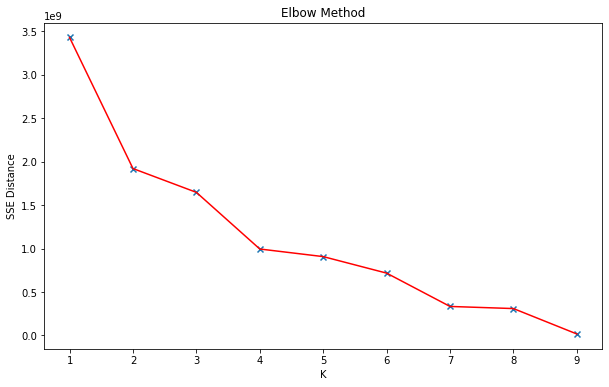

<Figure size 432x288 with 0 Axes>

In [12]:
fig = plt.figure(figsize=(10,6))
x=list(range(1,10))
labels=x
plt.plot(x,sse,'r')
plt.scatter(x,sse,marker='x')
plt.xticks(x, labels)
plt.title('Elbow Method')
plt.xlabel('K')
plt.ylabel('SSE Distance')
plt.show()
plt.savefig('elbow.png')

In [13]:
k = 5
random.seed(42)
#run it
clusters,centroids,elbow=kmeans(vals,k)
#output
data['c']=[int(c) for c in clusters]
lats = [centroids[i][1] for i in range(k)]
data['clat'] = data['c'].map(lambda x: lats[x])
longs = [centroids[i][2] for i in range(k)]
data['clong'] = data['c'].map(lambda x: longs[x])
#d['Count']= d.groupby('c')['Facility_Name'].nunique()
data.head()
data

,point_id,latitude,longitude,weight,c,clat,clong
0,379839017,12.856261,77.787511,5,1,12.869724,77.678396
1,622780526,12.843469,77.536688,2,2,12.903538,77.492630
2,294600617,12.976655,77.639975,1,4,12.930186,77.601398
3,160818599,12.855278,77.586485,1,4,12.930186,77.601398
4,32679861,12.843120,77.670582,2,1,12.869724,77.678396
...,...,...,...,...,...,...,...
295,719552775,12.958532,77.449353,4,2,12.903538,77.492630
296,751775783,13.017338,77.474820,2,3,13.043437,77.530075
297,690286657,13.130033,77.595974,1,3,13.043437,77.530075
298,636676599,12.810747,77.534776,1,2,12.903538,77.492630


In [14]:
c_lat=list(set(data['clat']))
c_long=list(set(data['clong']))
centroids=list(zip(c_lat,c_long))
m2 = folium.Map(
    location=[12.85,77.65],
    zoom_start=10.45)
for i in range(len(centroids)):
    folium.CircleMarker(centroids[i]).add_to(m2)
    
folium.LayerControl().add_to(m2)
m2

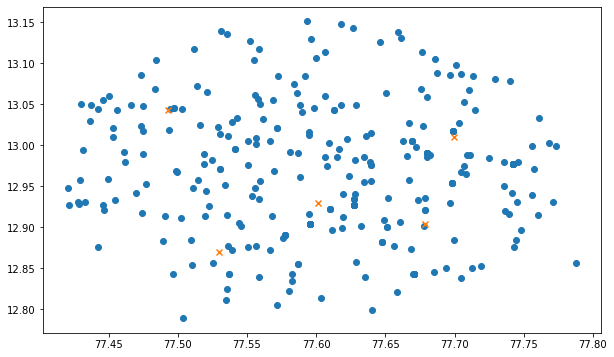

In [15]:
x1=data['latitude'].values.tolist()
y1=data['longitude'].values.tolist()
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(y1,x1)
plt.scatter(c_long,c_lat,marker='x')

In [16]:
centroids

[(12.869724155398233, 77.53007483764443),
 (13.00992870419214, 77.69985083126636),
 (13.043436627066665, 77.4926302989167),
 (12.903537968249998, 77.67839619292037),
 (12.930185600843378, 77.60139798289156)]

In [17]:
## Find the distance of centroid of each cluster to its corresponding cluster point

In [18]:
centroid_latitude, centroid_longitude = zip(*centroids)
centroid_latitude = {i:j for i,j in enumerate(list(centroid_latitude))}
centroid_longitude = {i:j for i,j in enumerate(list(centroid_longitude))}
data["centraiod_latitude"] = data.c.map(centroid_latitude)
data["centroid_longitude"] = data.c.map(centroid_longitude)
data['point_tuple'] = list(zip(data.latitude, data.longitude))
data['centroid_tuple'] = list(zip(data.centraiod_latitude, data.centroid_longitude))
data.head()

,point_id,latitude,longitude,weight,c,clat,clong,centraiod_latitude,centroid_longitude,point_tuple,centroid_tuple
0,379839017,12.856261,77.787511,5,1,12.869724,77.678396,13.009929,77.699851,"(12.856261, 77.787511)","(13.00992870419214, 77.69985083126636)"
1,622780526,12.843469,77.536688,2,2,12.903538,77.492630,13.043437,77.492630,"(12.843469, 77.536688)","(13.043436627066665, 77.4926302989167)"
2,294600617,12.976655,77.639975,1,4,12.930186,77.601398,12.930186,77.601398,"(12.976655000000001, 77.639975)","(12.930185600843378, 77.60139798289156)"
3,160818599,12.855278,77.586485,1,4,12.930186,77.601398,12.930186,77.601398,"(12.855278, 77.586485)","(12.930185600843378, 77.60139798289156)"
4,32679861,12.843120,77.670582,2,1,12.869724,77.678396,13.009929,77.699851,"(12.843119999999999, 77.670582)","(13.00992870419214, 77.69985083126636)"


In [19]:
data["cluster_distance"] = np.nan
for i in range(data.shape[0]):
    data.loc[i,"cluster_distance"] = haversine(data.loc[i,"point_tuple"],  data.loc[i,"centroid_tuple"])
data.head()

,point_id,latitude,longitude,weight,c,clat,clong,centraiod_latitude,centroid_longitude,point_tuple,centroid_tuple,cluster_distance
0,379839017,12.856261,77.787511,5,1,12.869724,77.678396,13.009929,77.699851,"(12.856261, 77.787511)","(13.00992870419214, 77.69985083126636)",19.550466
1,622780526,12.843469,77.536688,2,2,12.903538,77.492630,13.043437,77.492630,"(12.843469, 77.536688)","(13.043436627066665, 77.4926302989167)",22.742247
2,294600617,12.976655,77.639975,1,4,12.930186,77.601398,12.930186,77.601398,"(12.976655000000001, 77.639975)","(12.930185600843378, 77.60139798289156)",6.646466
3,160818599,12.855278,77.586485,1,4,12.930186,77.601398,12.930186,77.601398,"(12.855278, 77.586485)","(12.930185600843378, 77.60139798289156)",8.484756
4,32679861,12.843120,77.670582,2,1,12.869724,77.678396,13.009929,77.699851,"(12.843119999999999, 77.670582)","(13.00992870419214, 77.69985083126636)",18.817591


In [20]:
## Now we have 5 distribution centers and we need to allocate the total capacity of 853 units

In [21]:
data.weight.sum()
data.sort_values("c",ascending=True,inplace=True)

In [22]:
## Suppose an input to the algorithm is the number of units that could be transfered for each distribution center such 
##that the total sum is 853
data.weight.sum()

853

In [23]:
input_capacity = [101,150,220,225,157]
sum(input_capacity)

853

In [24]:
data.groupby("c")["weight"].sum()

c
0    229
1    113
2    120
3    225
4    166
Name: weight, dtype: int64

In [25]:
## Now for each cluster allocate the capacity in ascending order of its distance from cluster center

In [26]:
cluster_status = []
capacity_left_df = [] ## the data that is not allocated
capacity_left = [] ## capacitites that are left or unutilized
for i in data.c.unique().tolist():
    tmp = data.copy()
    tmp = tmp.loc[tmp.c==i,]
    tmp.sort_values("cluster_distance",ascending=True,inplace=True)
    tmp.reset_index(drop=True,inplace=True)
    allocated_capacity = input_capacity[i]
    tmp['cumsum_weights'] = tmp['weight'].cumsum()
    val = pd.Index(tmp.weight.cumsum()).get_loc(allocated_capacity, 'nearest')
    if(np.any(allocated_capacity in tmp.cumsum_weights.tolist())):
        if(allocated_capacity == tmp.cumsum_weights.tail(1).tolist()[0]):
            status = "Cluster # " + str(i) +" fully allocated and no capacity left"
            capacity_left.append(0)
        else:
            status = "Cluster # " + str(i) +" fully allocated and capacity left"
            capacity_left_df.append(tmp.iloc[val+1:,])  
            capacity_left.append(tmp.loc[val+1:,"weight"].sum())
    elif(allocated_capacity < tmp.cumsum_weights.tail(1).tolist()[0]):
        status = "Cluster # " + str(i) +" fully allocated and capacity left with updated weight"
        ## Update the weight
        if(allocated_capacity > tmp.loc[val,"cumsum_weights"]):
            val += 1
        tmp.loc[val,"weight"] = tmp.loc[val,"weight"] + (tmp.loc[val-1,"cumsum_weights"] - allocated_capacity)
        capacity_left_df.append(tmp.iloc[val:,])
        capacity_left.append(tmp.loc[val:,"weight"].sum())
    else:
        status = "Cluster # " + str(i) +" Not fully allocated"
        capacity_left.append(-(allocated_capacity - tmp.cumsum_weights.tail(1).tolist()[0]))
    
    cluster_status.append(status)

In [27]:
cluster_status

['Cluster # 0 fully allocated and capacity left with updated weight',
 'Cluster # 1 Not fully allocated',
 'Cluster # 2 Not fully allocated',
 'Cluster # 3 fully allocated and no capacity left',
 'Cluster # 4 fully allocated and capacity left with updated weight']

In [28]:
capacity_left

[128, -37, -100, 0, 9]

In [29]:
sum(capacity_left)

0

In [30]:
## Only Not fully allocated distribution could serve the capacity left

In [31]:
unallocated_data = pd.concat(capacity_left_df,axis=0).iloc[:,:-2]
unallocated_data.reset_index(drop=True,inplace=True)
unallocated_data.head()

,point_id,latitude,longitude,weight,c,clat,clong,centraiod_latitude,centroid_longitude,point_tuple,centroid_tuple
0,695118714,12.950598,77.735499,2,0,13.009929,77.699851,12.869724,77.530075,"(12.95059805, 77.73549944)","(12.869724155398233, 77.53007483764443)"
1,505163357,12.941465,77.741600,2,0,13.009929,77.699851,12.869724,77.530075,"(12.941464999999999, 77.7416)","(12.869724155398233, 77.53007483764443)"
2,408721699,13.017458,77.698665,2,0,13.009929,77.699851,12.869724,77.530075,"(13.017458, 77.698665)","(12.869724155398233, 77.53007483764443)"
3,134225455,13.017458,77.698665,4,0,13.009929,77.699851,12.869724,77.530075,"(13.017458, 77.698665)","(12.869724155398233, 77.53007483764443)"
4,250845312,13.017458,77.698665,1,0,13.009929,77.699851,12.869724,77.530075,"(13.017458, 77.698665)","(12.869724155398233, 77.53007483764443)"


In [32]:
##Now for the unallocated data, we need to find the distance with all cluster centroids that are not fully allocated

In [33]:
idx = np.argwhere(np.array(capacity_left) < 0)
idx = [idx[c][0] for c in range(len(idx))]
idx

[1, 2]

In [34]:
lst = []
for i in range(len(idx)):
    unallocated_data[f"{idx[i]}_centroid_tuple_step2"] =  pd.Series((data.loc[data.c == int(idx[i]),"centroid_tuple"].head(1).tolist()[0],)*unallocated_data.shape[0])
    unallocated_data[f"{idx[i]}_centroid_distance_step2"] = np.nan
    for j in range(unallocated_data.shape[0]):
        unallocated_data.loc[j,f"{idx[i]}_centroid_distance_step2"] = haversine(unallocated_data.loc[j,"point_tuple"],  unallocated_data.loc[i,f"{idx[i]}_centroid_tuple_step2"])
unallocated_data.head()


,point_id,latitude,longitude,weight,c,clat,clong,centraiod_latitude,centroid_longitude,point_tuple,centroid_tuple,1_centroid_tuple_step2,1_centroid_distance_step2,2_centroid_tuple_step2,2_centroid_distance_step2
0,695118714,12.950598,77.735499,2,0,13.009929,77.699851,12.869724,77.530075,"(12.95059805, 77.73549944)","(12.869724155398233, 77.53007483764443)","(13.00992870419214, 77.69985083126636)",7.644881,"(13.043436627066665, 77.4926302989167)",28.266505
1,505163357,12.941465,77.741600,2,0,13.009929,77.699851,12.869724,77.530075,"(12.941464999999999, 77.7416)","(12.869724155398233, 77.53007483764443)","(13.00992870419214, 77.69985083126636)",8.855482,"(13.043436627066665, 77.4926302989167)",29.261638
2,408721699,13.017458,77.698665,2,0,13.009929,77.699851,12.869724,77.530075,"(13.017458, 77.698665)","(12.869724155398233, 77.53007483764443)","(13.00992870419214, 77.69985083126636)",0.847020,"(13.043436627066665, 77.4926302989167)",22.506272
3,134225455,13.017458,77.698665,4,0,13.009929,77.699851,12.869724,77.530075,"(13.017458, 77.698665)","(12.869724155398233, 77.53007483764443)","(13.00992870419214, 77.69985083126636)",0.847020,"(13.043436627066665, 77.4926302989167)",22.506272
4,250845312,13.017458,77.698665,1,0,13.009929,77.699851,12.869724,77.530075,"(13.017458, 77.698665)","(12.869724155398233, 77.53007483764443)","(13.00992870419214, 77.69985083126636)",0.847020,"(13.043436627066665, 77.4926302989167)",22.506272


In [35]:
## Now start allocating the cluster with minimum count of capacity shortage first, this will give a local optimal solution

In [36]:
initial_capacity = (list(np.array(capacity_left)[idx]))
drop_cluster = initial_capacity.copy()
for col in unallocated_data.c.value_counts()[::-1].index:
    print("Allocating in clutser number:: ", col)
    tmp = unallocated_data.copy()
    tmp = tmp.loc[tmp.c==col,]
    ## Sort by weight to prioritize the large parcels
    tmp.sort_values("weight",ascending=False,inplace=True)
    tmp.reset_index(drop=True,inplace=True)
    ## Filtering out the columns that has distance computation
    temp = tmp.filter(regex="_distance_step2")
    drop_lst = []
    used_idx = [index for index, value in enumerate(initial_capacity)]
    
    for j in range(tmp.shape[0]):
        print(initial_capacity)
        ## As soon as the capacity is fully utilized in a cluster, we have drop it for further allocation
        ## created used_idx to check only of clusters with utilization left
        if ((initial_capacity[np.argmin(temp.iloc[j])] + tmp.loc[j,"weight"]) > 0) & (len(used_idx) > 1):            
            drop_cluster[np.argmin(temp.iloc[j])] = drop_cluster[np.argmin(temp.iloc[j])] + tmp.loc[j,"weight"]  
            drop_lst.append(drop_cluster.index(min([i for i in drop_cluster if i > 0])))
            used_idx = [c for c in  used_idx if c not in drop_lst]
        ## only if we have more than 1 cluters, we could compare between the two for finding the minimum distance and allocation
        if (len(used_idx) > 1):
            initial_capacity[np.argmin(temp.iloc[j,used_idx])] = initial_capacity[np.argmin(temp.iloc[j,used_idx])] + tmp.loc[j,"weight"]
        ## If there is only one cluster left, then iteratively allocate in it, till it is fully utilized
        else:
            ## There will scenarios where some little allocation left due to weight in the priority higher than the capacity
            ## print out the results to check for such instances
            if(initial_capacity[used_idx[0]] >= 0):
                print("----------------------------------------")
                print("Unallocated parcels ")
                print("----------------------------------------")
                print(tmp.iloc[j:,])
                print("----------------------------------------")
                print("Total size of unallocation:::")
                print((tmp.iloc[j:,]).shape[0])
                break
            initial_capacity[used_idx[0]]  = initial_capacity[used_idx[0]]  + tmp.loc[j,"weight"]
    

Allocating in clutser number::  4
[-37, -100]
[-34, -100]
[-32, -100]
[-30, -100]
[-29, -100]
Allocating in clutser number::  0
[-28, -100]
[-23, -100]
[-18, -100]
[-13, -100]
[-8, -100]
[-3, -100]
[-3, -95]
[-3, -90]
[-3, -85]
[-3, -81]
[-3, -77]
[-3, -73]
[-3, -69]
[-3, -65]
[-3, -61]
[-3, -57]
[-3, -53]
[-3, -49]
[-3, -46]
[-3, -43]
[-3, -40]
[-3, -37]
[-3, -34]
[-3, -31]
[-3, -29]
[-3, -27]
[-3, -25]
[-3, -23]
[-3, -21]
[-3, -19]
[-3, -17]
[-3, -15]
[-3, -13]
[-3, -11]
[-3, -9]
[-3, -7]
[-3, -6]
[-3, -5]
[-3, -4]
[-3, -3]
[-3, -2]
[-3, -1]
[-3, 0]
----------------------------------------
Unallocated parcels 
----------------------------------------
     point_id   latitude  longitude  weight  c       clat      clong  \
42  289244475  12.977135  77.742475       1  0  13.009929  77.699851   
43   97830717  12.977135  77.742475       1  0  13.009929  77.699851   
44  654967982  13.138172  77.659212       1  0  13.009929  77.699851   

    centraiod_latitude  centroid_longitude        

In [37]:
## Now we have 3 capacity left, which would be fulfilled by the cluster number 4

In [38]:
## Hence the parcels are fully allocated 